In [1]:
import os.path

import tensorflow as tf

import re
import pandas as pd
from tokenization import FullTokenizer

In [2]:
DELIMITER = '|'
seq_length = 128

BATCH_SIZE = 128
BUFFER_SIZE = 10000
EPOCHS = 30

In [3]:
dataset_df = pd.read_csv('dataset.csv', dtype=str, delimiter=DELIMITER).sample(frac=1)

lyrics = dataset_df['lyrics'].str.cat()
lyrics = re.sub(r'\n{3,}', '\n', lyrics)

In [4]:
tokenizer = FullTokenizer(spm_model_file='sp_model.model')
print(f'{tokenizer.vocab_size} unique characters')

loading sentence piece model
500 unique characters


In [5]:
tokens = tokenizer.tokenize(lyrics)
all_ids = tf.convert_to_tensor(tokens, dtype=tf.int16)
print(all_ids)

ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True, name="batched_lyrics_as_ids")
sequences

tf.Tensor([ 56  31  22 ...  26 199  20], shape=(6080163,), dtype=int16)


<BatchDataset element_spec=TensorSpec(shape=(129,), dtype=tf.int16, name=None)>

In [6]:
for seq in sequences.take(1):
  print(tokenizer.convert_ids_to_tokens(seq.numpy().tolist()))
  print(tokenizer.detokenize(seq.numpy().tolist()))

['▁You', '▁and', '▁me', ',', '▁we', '▁made', '▁a', '▁', 'v', 'ow', '\n', 'F', 'or', '▁better', '▁or', '▁for', '▁w', 'or', 'se', '\n', 'I', '▁can', "'", 't', '▁believe', '▁you', '▁let', '▁me', '▁down', '\n', 'B', 'ut', '▁the', '▁', 't', 'ru', 'th', "'", 's', '▁in', '▁the', '▁way', '▁it', '▁hurt', 's', '\n', 'F', 'or', '▁mo', 'n', 'th', 's', '▁on', '▁', 'end', '▁I', "'", 've', '▁had', '▁my', '▁do', 'u', 'b', 't', 's', '\n', 'D', 'en', 'y', 'ing', '▁every', '▁te', 'ar', '\n', 'I', '▁wish', '▁this', '▁would', '▁be', '▁over', '▁now', '\n', 'B', 'ut', '▁I', '▁know', '▁that', '▁I', '▁still', '▁need', '▁you', '▁here', '\n', '\n', 'Y', 'o', 'u', '▁say', '▁I', "'", 'm', '▁crazy', '\n', "'", 'Cause', '▁you', '▁don', "'", 't', '▁think', '▁I', '▁know', '▁what', '▁you', "'", 've', '▁don', 'e', '\n', 'B', 'ut', '▁when', '▁you', '▁call', '▁me', '▁baby', '\n', 'I', '▁know']
You and me, we made a vow
For better or for worse
I can't believe you let me down
But the truth's in the way it hurts
For months o

In [7]:
def split_input_target(sequence: list[str]) -> tuple[list[str], list[str]]:
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text, target_text

In [8]:
dataset = (
    sequences
    .map(split_input_target)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(128, 128), dtype=tf.int16, name=None), TensorSpec(shape=(128, 128), dtype=tf.int16, name=None))>

In [9]:
from model import MyModel
model = MyModel(vocab_size=tokenizer.vocab_size,
                embedding_dim=256,
                rnn_units=1024)

loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.optimizers.Adamax()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [22]:
import os

model_dir = './model'
if os.path.exists(model_dir):
    model.load_weights(tf.train.latest_checkpoint(model_dir))
    print('Loaded Weights')

Loaded Weights


In [21]:
history = model.fit(dataset, epochs=EPOCHS,)
model.save_weights(os.path.join(model_dir, "weights"))

Epoch 1/30
 77/368 [=====>........................] - ETA: 35s - loss: 1.8970 - accuracy: 0.5584


KeyboardInterrupt



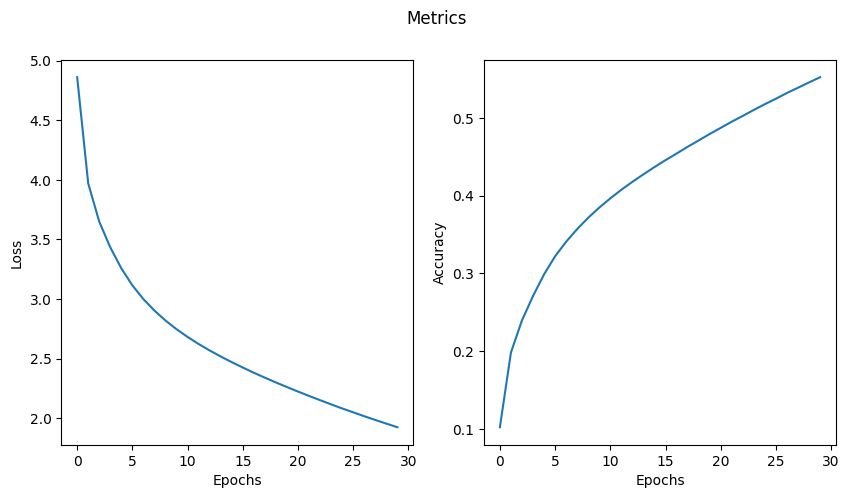

In [11]:
from matplotlib import pyplot as plt


def plot_graphs(_history):
    fig, axs = plt.subplots(1, len(_history.items()), figsize=(10,5))
    fig.suptitle("Metrics")
    for i, (title, values) in enumerate(_history.items()):
        axs[i].plot(values)
        axs[i].set_xlabel("Epochs")
        axs[i].set_ylabel(title.title())
    plt.show()


plot_graphs(history.history)

In [12]:
from abc import ABC

class OneStep(tf.keras.Model, ABC):
    def __init__(self, model, tokenizer: FullTokenizer, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model = model
        self.tokenizer = tokenizer

        # Create a mask to prevent "[UNK]" from being generated.
        skip_ids = tf.constant([[tokenizer.sp_model.unk_id()]], dtype=tf.int64)
        sparse_mask = tf.SparseTensor(
            # Put an -inf at each bad index.
            values=[-float('inf')]*len(skip_ids),
            indices=skip_ids,
            # Match the shape to the vocabulary
            dense_shape=[tokenizer.vocab_size])
        self.prediction_mask = tf.sparse.to_dense(sparse_mask)
        # inputs = tf.TensorSpec(shape=[None], dtype=tf.string)
        # states = [tf.TensorSpec(shape=[None, None], dtype=tf.float32) for _ in range(4)]
        # temperature = tf.TensorSpec(shape=None, dtype=tf.float32)
        # steps = tf.TensorSpec(shape=None, dtype=tf.int32)
        # self.generate.get_concrete_function(inputs, states, temperature, steps)

    # @tf.function
    def generate(self, inputs: str, states=None, temperature: float = 1.0, steps: int = 200):
        tokens = self.tokenizer.tokenize(inputs)
        output_array = tf.TensorArray(dtype=tf.int64, dynamic_size=True, size=0)
        for i in tf.range(0, len(tokens)):
            output_array = output_array.write(output_array.size(), tokens[i])

        for _ in tf.range(steps):
            inputs = tf.convert_to_tensor([output_array.stack()])
            predicted_logits, states = self.model(inputs=inputs, states=states,
                                                  return_state=True)
            # Only use the last prediction.
            predicted_logits = predicted_logits[:, -1, :]
            predicted_logits = predicted_logits / temperature
            # Apply the prediction mask: prevent "[UNK]" from being generated.
            predicted_logits = predicted_logits + self.prediction_mask

            # Sample the output logits to generate token IDs.
            predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
            predicted_ids = tf.squeeze(predicted_ids, axis=-1)
            output_array = output_array.write(output_array.size(), predicted_ids[0])

        return self.tokenizer.detokenize(output_array.stack().numpy().tolist())

In [13]:
one_step = OneStep(model, tokenizer)

In [14]:
test = "i am capable of"
states = None
print(one_step.generate(test, steps = 500))

i am capable oftent rain

Tied once as the ruin, I am gonna heaveHeaven setting
They're better off?

I'm so fucking brazy
I got a bad girl different in the deno
But while I'm droppin' the club in how I'm lie
I'm 'bout to go crazy, selling vibes
It's on the top, it's a roof, train tangerin' bursting
Point back to Palray, Big Money like a tramp
I'm whipping out feed and show 'em so we keep as equals
I get the dough block off the Roc 'cause they runnin' shit up
My shit is a cool in this, cost a pistol on the couch
And you ain't gotta say too much, get thinkin' 'bout us, need some head
Make you say was any page, you can never find out the sound
Off Black World nigga, they done braggin'
Now if you cag up they never saw the whole world for some people use to?
Eyes ready for the fact that you gotta pull it back
Ain't gotta got you in my bed, rertant, can you still see the game?"
What am I no doing?At you hate it when only I see I'm hanging by rhymes
Got me thinkin' about to, envy mata what I 